# Finetuning Stable Diffusion

In [1]:
# fix locale, to prevent future flaky errors

import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!pip install diffusers
!pip install transformers scipy ftfy accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.9/934.9 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.8 MB/s eta 0:00:00


In [3]:
# import libraries

import os
import torch
import numpy as np

from diffusers import StableDiffusionPipeline
from PIL import Image
from scipy.spatial.distance import cosine
from transformers import BlipProcessor, BlipForConditionalGeneration

In [4]:
# create folders if they don't exist already

folder_names = ['embeddings', 'images', 'models']

# check and create folders if they don't exist
for folder_name in folder_names:
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        print(f"Folder '{folder_name}' created.")
    else:
        print(f"Folder '{folder_name}' already exists.")

Folder 'embeddings' created.
Folder 'images' created.
Folder 'models' created.


For this to work we need a specific use case so we can use images of it. Since I found a cool dataset that has images of Pokemon with a BLIP generated caption of it. Also who doesn't like Pokemon? So let's use this: 

Data Source: https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions

Install training scripts and dependencies:

In [6]:
!git clone https://github.com/huggingface/diffusers
!pip install ./diffusers
!pip install -r ./diffusers/examples/text_to_image/requirements.txt

fatal: destination path 'diffusers' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.17.0.dev0-py3-none-any.whl size=1073732 sha256=b573f657e11e59e26396fd1fa8b945f7e7253fcaadd1825780f336dcd2f42300
  Stored in directory: /tmp/pip-ephem-wheel-cache-3howuinq/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.16.1
    Uninstalling diffusers-0.16.1:
      Successfully uninstalled diffusers-0.16.1


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.9 MB/s eta 0:00:00


In [7]:
!accelerate config default

2023-06-02 16:42:06.492371: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [8]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
!accelerate launch --mixed_precision="fp16" ./diffusers/examples/text_to_image/train_text_to_image.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v-1-4" \
  --dataset_name="lambdalabs/pokemon-blip-captions" \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=15000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir="sd-pokemon-model" 

2023-06-02 15:02:27.540328: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-02 15:02:32.269024: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
06/02/2023 15:02:35 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_errors.py:259 │
│ in hf_raise_for_status                                                       │
│                                                                              │
│   256 │   </Tip>                              

# With LoRA

In [9]:
!accelerate launch --mixed_precision="fp16" diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4" \
  --dataset_name="lambdalabs/pokemon-blip-captions" --caption_column="text" \
  --resolution=512 --random_flip \
  --train_batch_size=1 \
  --num_train_epochs=1 --checkpointing_steps=5000 \
  --learning_rate=1e-04 --lr_scheduler="constant" --lr_warmup_steps=0 \
  --seed=42 \
  --output_dir="sd-pokemon-model-lora" \
  --validation_prompt="cute dragon creature"

2023-06-02 16:43:15.934010: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-02 16:43:21.484194: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:258: FutureWarning: `logging_dir` is deprecated and will be removed in version 0.18.0 of 🤗 Accelerate. Use `project_dir` instead.
  warnings.warn(
06/02/2023 16:43:23 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'thresholding', 'dynamic_thresholding_ratio', 'sample_max_value', 'prediction_type', 'clip_sample_range', 'variance_type'} was not found in config. Values will be initialized to default values.
{'norm_num_groups'} was not found in config. Values will be initialized to default values.
{'dual_cross_attention', 'class_embeddings_concat', 'use_linear_projection', 'time_emb

## Inference:

In [14]:
pipe = StableDiffusionPipeline.from_pretrained('CompVis/stable-diffusion-v1-4', torch_dtype=torch.float16)
pipe.unet.load_attn_procs('./sd-pokemon-model-lora/pytorch_lora_weights.bin')

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [15]:
pipe.to('cuda')

image = pipe(prompt='a dragon with fire').images[0]
image.save('images/image1.png')

  0%|          | 0/50 [00:00<?, ?it/s]

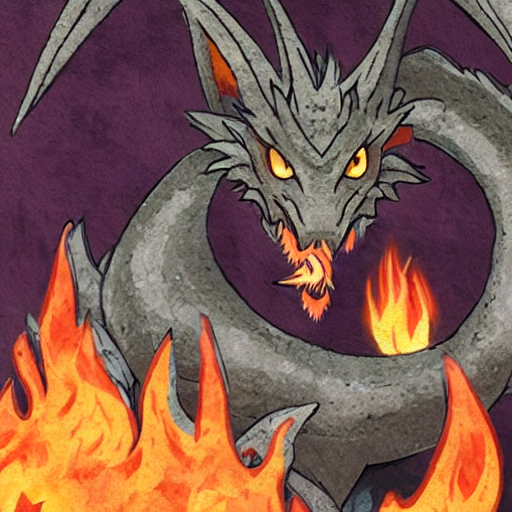

In [16]:
image.show()